# Computational tools for data science: Comparing Recommendation Systems for MillionSongsDataset

In [20]:
# Imports
import math
import os
import pickle
import pprint
import re
import statistics
import time
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from datasketch import MinHash, MinHashLSHForest
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

import hdf5_getters as hdf5_getters

/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/__init__.py:24: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/__init__.py:24: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/req_versions.py:20: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  min_numpy_version = LooseVersion('1.9.3')
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/req_versions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  min_numexpr_version = LooseVersion('2.6.2')
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/tables/req_versions.py:22: Deprecati

## Read the data

Assuming that you have all the data in a folder called ```data```

In [3]:
# Read the songs dataset
with ZipFile('data/songs_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

songs_cleaned = pd.read_csv(BytesIO(data))

In [4]:
# And pre-process the artist_terms feature

def ConvertStringtoList(string):
    s = string.replace('[','')
    s = s.replace(']','')
    s = s.replace('\'','')
    s = s.replace(' ','')
    li = list(s.split(","))
    return li

i = 0
for string in songs_cleaned['artist_terms']:
    list_ = ConvertStringtoList(string)
    songs_cleaned['artist_terms'][i] = list_
    i += 1

In [5]:
songs_cleaned.head()

,artist_id,song_id,artist_terms
0,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,"[blue-eyedsoul, poprock, blues-rock, beachmusi..."
1,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,"[poppunk, skapunk, breakcore, alternativemetal..."
2,AR10USD1187B99F3F1,SOHKNRJ12A6701D1F8,"[post-hardcore, screamo, emo, hardcore, punkre..."
3,ARC43071187B990240,SOKEJEJ12A8C13E0D0,"[ccm, religiousmusic, losangeles, christianroc..."
4,ARL7K851187B99ACD2,SOMUYGI12AB0188633,"[bachata, merengue, reggaeton, latinpop, spani..."


In [6]:
# Read the user tastes' dataset

with ZipFile('users_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

users_cleaned = pd.read_csv(BytesIO(data))
print(len(users_cleaned))
users_cleaned.head()

697064


,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODCXXY12AB0187452,2
2,b64cdd1a0bd907e5e00b39e345194768e330d652,SOLXDDC12A6701FBFD,1
3,b64cdd1a0bd907e5e00b39e345194768e330d652,SONQBUB12A6D4F8ED0,2
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1


In [12]:
# How many different users there are
print("We have a total of", len(set(users_cleaned['userID'])), "users.")

# Let's take a subset of users to evaluate the performance of the various recommendation systems
nb_of_users = 5000

users_subset = users_cleaned[users_cleaned['userID'].isin(list(set(users_cleaned['userID']))[:nb_of_users])]
print("In the subset for the evaluation we have a total number of", len(set(users_subset['userID'])), "users.")

We have a total of 386670 users.
In the subset for the evaluation we have a total number of 5000 users.


## Content based recommendation

### Represent songs as vectors

We use the feature artist_terms and implement one-hot-encoding. With one-hot-encoding, we convert each categorical value into a new categorical column and assign a binary value 1 or 0 to each feature if the term was initially in the terms of a song.

In [7]:
df_songs = songs_cleaned

In [13]:
# First, extract the set of artist_terms

all_terms = []
for row in range(len(df_songs)):
    if df_songs['artist_terms'][row] == []:
        print('vacia')
    all_terms.append(df_songs['artist_terms'][row])

all_terms = np.concatenate(all_terms)
all_terms = list(set(all_terms)) # we have gotten a list of the set of all artist_terms

d = len(all_terms) # dimension of the vectors we are representing
print('Songs will be represented as binary vectors of dimension', d)

Songs will be represented as binary vectors of dimension 2294


In [14]:
# Now, we intend to create a binary vector (length = d) that represents a song, 
# with 1s if the song has this term and 0s if it hasn't.

def vectorize(song):

    index = int(df_songs.index[df_songs['song_id'] == song][0])
    vector = np.zeros(len(all_terms))

    for i in range(len(vector)):
        if all_terms[i] in df_songs['artist_terms'][index]:
            vector[i] = 1
            
    return vector

In [15]:
# Vectorize ALL the songs and save it into a dictionary

vector_representation = {}

for song in df_songs['song_id']:
    vector_representation[song] = vectorize(song)
    
#vector_representation # we end up with a dictionary of songs with their vector representation

### Get the user profiles

We will represent each user as a vector of dimension d. 
The representation is the weighted average of the songs that the user has already listened to.

In [16]:
# Compute all the results only for the subset of 5000 users
user_plays = users_subset

In [17]:
# Get the User profile: that will be a vector of dimension d computed as the weighted average of his played songs
# Get user profile for all users

def getUserProfile(user):

    song_counts = list(user_plays[user_plays['userID'] == user]['play_count'])
    song_list = list(user_plays[user_plays['userID'] == user]['songID'])


    # Check if the user songs are in the song dataset and get the indices of the songs
    indices = []
    for song in song_list:
        if song in list(df_songs['song_id']):
            indices.append(song_list.index(song))
        else:
            continue


    # Get the User profile (i.e. Compute the (weighted) average of the songs of a user)
    a = [song_counts[i] for i in indices]
    b = [vector_representation[song_list[i]] for i in indices]

    numerator = np.zeros(d)
    for i in range(len(a)):
        numerator = numerator + ( a[i] * np.asarray(b[i]) )

    user_profile = numerator / sum(a)
    return user_profile

In [22]:
# Get user profiles for every user in the users_plays dataset
# If users_plays = users_cleaned --> Very slow cell (it lasts 1 day). Set to True to run this cell. Or, read the already created dictionary in the file user_profiles.pkl
# Otherwise if users_plays = users_subset, (since it is a subset) OK.

create_user_profiles = True

if create_user_profiles:
    users = set(list(user_plays['userID']))
    user_profiles = {}
    for user in tqdm(users):
        user_profiles[user] = getUserProfile(user)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [24]:
# Save dictionary of user_profiles
# Set to True if you want to save the user_profiles dictionary as a separate file
if create_user_profiles:
    with open("user_profiles.pkl", "wb") as f:
        pickle.dump(user_profiles, f)

In [25]:
# Read user_profiles file and save it into a dictionary
if not create_user_profiles:
    with open("user_profiles.pkl", "rb") as a_file:
        user_profiles = pickle.load(a_file)
print("We have", len(user_profiles), "users in this dictionary.")

We have 5000 users in this dictionary.


### Get recommendation

We will recommend the songs of our dataset that are more similar to the user profile.

In [26]:
# Recommendations for all users

def getRecommendation(user):
    user_profile = user_profiles[user]
    
    scores_dict = {}
    for song in df_songs['song_id']:
        dist = np.linalg.norm(user_profile - vector_representation[song]) # euclidean distance
        scores_dict[song] = dist

    # R best recommendations
    R = 10
    recommended_songs = []
    for score in np.sort(list(scores_dict.values()))[0:R]:
        recommended_songs.append(list({i for i in scores_dict if scores_dict[i]==score}))

    recommended_songs = list(set(np.concatenate(recommended_songs)))

    return recommended_songs

In [29]:
# Create dictionary of user_recommendations
# Set to True if you want to create it again.
# If users_plays = users_cleaned --> Very slow cell (it takes forever)
# Otherwise if users_plays = users_subset, OK.
if True:
    user_recommendations = {}
    for key in tqdm(user_profiles.keys()):
        if counter < 10000: # control parameter, if we have more than a certain nb of users, don't compute it all
            user_recommendations[key] = getRecommendation(key)
        else:
            break

  0%|          | 0/5000 [00:00<?, ?it/s]

In [30]:
# For how many users I get a recommendation
len([key for key in user_profiles.keys() if user_recommendations[key] != []])

5000

In [34]:
# Save dictionary of user_recommendations
# Set to True if you want to save the user_recommendations dictionary as a separate file
save_user_recommendations = True
if save_user_recommendations:
    with open("user_recommendations.pkl", "wb") as f:
        pickle.dump(user_recommendations, f)

In [35]:
# Read user_recommendations file and save it into a dictionary
if not save_user_recommendations:
    with open("user_recommendations.pkl", "rb") as a_file:
        user_recommendations = pickle.load(a_file)
    print("We have", len(user_recommendations), "users with their recommendations.")

We have 5000 users with their recommendations.


### Example of recommendation to a user

In [43]:
user = 'a0fd5b01256fe926075f5d2fc1696a635a3df2ba'

user_recommendations[user] # song_id of recommended songs

['SOQVXCF12AF72A419B',
 'SOQSNYP12A8AE47348',
 'SOIZLKI12A6D4F7B61',
 'SOAERUU12A8C13F302',
 'SOLEETW12A6D4FB2FE',
 'SOXFSTR12A8AE463B0',
 'SOMMSMW12A8C13FCCC',
 'SOYCHDB12A8C13F2C8',
 'SOLLCFT12A58A7A566',
 'SOBVAPJ12AB018739D',
 'SORJVDO12AF72A1970',
 'SOGAALD12A6D4F58F2',
 'SOMTYLD12AF72A6883',
 'SOAUGJA12AB01869AF',
 'SOEIQUY12AF72A086A',
 'SOSXERI12AB0190244']

### Evaluation of recommendation

We can use different methods:

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [36]:
# Cosine similarity
from numpy.linalg import norm
def cosine_similarity(song1, song2):
    a = vector_representation[song1]
    b = vector_representation[song2]
    dist = np.dot(a,b)/(norm(a)*norm(b))
    return dist

average_distances_for_user = []
for user,rec in user_recommendations.items():
    # All possible pairs in List
    pairs = [(a, b) for idx, a in enumerate(rec) for b in rec[idx + 1:]]
    
    # Compute the average distances between the pairs of the recommended songs
    distances = []
    for pair in pairs:
        distances.append(cosine_similarity(pair[0], pair[1]))
    
    average_distances_for_user.append(np.mean(distances))

In [37]:
# Get the intra-list similarity of the model
np.mean(average_distances_for_user)

0.5221922722146671

#### Personalization (in progress)

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

#### Evaluation that I explain in the whatsapp video (Ale)

In [38]:
# Compute the average of the distances of the recommended songs to the user profile 
# Distance can be calculated by euclidean or cosine similarity

average_distances_for_user = []
for user, rec in user_recommendations.items():
    user_profile = user_profiles[user]

    distances = []
    for song in rec:
        a = vector_representation[song]
        distances.append(np.linalg.norm(a-user_profile)) # euclidean distance
    
    average_distances_for_user.append(np.mean(distances))

In [39]:
# Get the score for the entire model
np.mean(average_distances_for_user)

3.1103882122362383

# User-user Collaborative filtering

The original file contains
- 1,019,318 unique users
- 48,373,586 user-song.play count triplets

A subset of 50000 triplets can be found in triplets_50000.txt, where each line is in the format:
    
    userID \tab songID \tab play_count

Read in the data:

In [49]:
user_profiles = pd.read_csv('data/triplets_1000.txt', sep='\t', names = ['userID','songID', 'play_count'])

The problem: the original dataset of triplets is too large to be converted in this way.
Possible solutions:
1. dtype optimization
2. Split data into chunks

In [50]:
user_profiles

,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
995,5a905f000fc1ff3df7ca807d57edb608863db05d,SOYPJMP12AF72A901D,1
996,5a905f000fc1ff3df7ca807d57edb608863db05d,SOYRHNG12A8C14002E,1
997,5a905f000fc1ff3df7ca807d57edb608863db05d,SOYVSHP12A6702016E,2
998,5a905f000fc1ff3df7ca807d57edb608863db05d,SOYYYFE12A81C2395E,1


Pivot to tranform the data from long to wide:

In [51]:
user_profiles = user_profiles.pivot(index='userID', columns='songID', values='play_count')
user_profiles

songID,SOAARXR12A8C133D15,SOABRAB12A6D4F7AAF,SOACPBY12A8C13FEF9,SOACWYB12AF729E581,SOADGFH12A8C143D89,SOADQPP12A67020C82,SOAFOBL12AF72A25BA,SOAFPAX12AB0187A17,SOAFTRR12AF72A8D4D,SOAIILB12A58A776F7,...,SOZMJFG12AB017BDAF,SOZMNAX12A58A77F88,SOZNBQP12A6310D8AA,SOZOBWN12A8C130999,SOZPQES12A6D4F8E57,SOZRBOZ12A58A7AD7E,SOZRLJL12A8C14415F,SOZVCRW12A67ADA0B7,SOZWVEH12A6D4F7C37,SOZZHXI12A8C13BF7D
userID,,,,,,,,,,,,,,,,,,,,,
17aa9f6dbdf753831da8f38c71b66b64373de613,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4bd88bfb25263a75bbdd467e74018f4ae570e5df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5a905f000fc1ff3df7ca807d57edb608863db05d,NaN,NaN,NaN,NaN,11.0,NaN,12.0,NaN,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85c1f87fea955d09b4bec2e36aee110927aedf9a,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8937134734f869debcab8f23d77465b4caaa85df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969cc6fb74e076a68e36a04409cb9d3765757508,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
9bb911319fbc04f01755814cb5edb21df3d1a336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b64cdd1a0bd907e5e00b39e345194768e330d652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


Drop the columns where all elements are NaN

In [52]:
user_profiles = user_profiles.dropna(axis=1, how='all') #doesn't make sense, a song will only exist if a user has listend to it
user_profiles

songID,SOAARXR12A8C133D15,SOABRAB12A6D4F7AAF,SOACPBY12A8C13FEF9,SOACWYB12AF729E581,SOADGFH12A8C143D89,SOADQPP12A67020C82,SOAFOBL12AF72A25BA,SOAFPAX12AB0187A17,SOAFTRR12AF72A8D4D,SOAIILB12A58A776F7,...,SOZMJFG12AB017BDAF,SOZMNAX12A58A77F88,SOZNBQP12A6310D8AA,SOZOBWN12A8C130999,SOZPQES12A6D4F8E57,SOZRBOZ12A58A7AD7E,SOZRLJL12A8C14415F,SOZVCRW12A67ADA0B7,SOZWVEH12A6D4F7C37,SOZZHXI12A8C13BF7D
userID,,,,,,,,,,,,,,,,,,,,,
17aa9f6dbdf753831da8f38c71b66b64373de613,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4bd88bfb25263a75bbdd467e74018f4ae570e5df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5a905f000fc1ff3df7ca807d57edb608863db05d,NaN,NaN,NaN,NaN,11.0,NaN,12.0,NaN,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85c1f87fea955d09b4bec2e36aee110927aedf9a,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8937134734f869debcab8f23d77465b4caaa85df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969cc6fb74e076a68e36a04409cb9d3765757508,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
9bb911319fbc04f01755814cb5edb21df3d1a336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b64cdd1a0bd907e5e00b39e345194768e330d652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


In [53]:
# Replace the NaN with 0s.
user_profiles = user_profiles.fillna(0)

In [54]:
#save it as a csv (do it only once)
#user_profiles.to_csv(path_or_buf= 'user_profile_from_50000_triplets.csv')

Get **cosine similarity** for play counts between users

In [55]:
# pairwise_distances is the distance between counts, thus 1 - pairwise_distances is the similarity between counts
cosine_sim = 1-pairwise_distances(user_profiles , metric="cosine")

In [56]:
# Calculate the cosine similarity matrix for the users
M_cosine = pd.DataFrame(cosine_sim)
M_cosine

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.00000,0.000000,0.000460,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.00000,1.000000,0.026845,0.0,0.000000,0.000000,0.000000,0.000000,0.007645,0.000000,0.00000,0.000000,0.000000
2,0.00046,0.026845,1.000000,0.0,0.039402,0.002493,0.004943,0.064458,0.034851,0.000000,0.13721,0.000173,0.000000
3,0.00000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.00000,0.000000,0.039402,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,0.00000,0.000000,0.002493,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.013717,0.000000
6,0.00000,0.000000,0.004943,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
7,0.00000,0.000000,0.064458,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
8,0.00000,0.007645,0.034851,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.003045,0.00000,0.002877,0.009309
9,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003045,1.000000,0.00000,0.000000,0.008786


Get **pearson similarity** for all users

In [57]:
pearson_sim = 1-pairwise_distances(user_profiles, metric="correlation")
M_pearson = pd.DataFrame(pearson_sim)
M_pearson

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000,-0.033196,-0.159660,-0.044875,-0.032843,-0.039742,-0.029074,-0.032717,-0.100910,-0.081124,-0.032498,-0.062920,-0.041540
1,-0.033196,1.000000,-0.022217,-0.014686,-0.010749,-0.013006,-0.009515,-0.010707,-0.024962,-0.026550,-0.010636,-0.020592,-0.013595
2,-0.159660,-0.022217,1.000000,-0.070875,-0.007531,-0.059955,-0.040363,0.020860,-0.118452,-0.128125,0.103060,-0.099177,-0.065607
3,-0.044875,-0.014686,-0.070875,1.000000,-0.014530,-0.017582,-0.012863,-0.014474,-0.044644,-0.035890,-0.014378,-0.027836,-0.018378
4,-0.032843,-0.010749,-0.007531,-0.014530,1.000000,-0.012868,-0.009414,-0.010593,-0.032674,-0.026267,-0.010523,-0.020373,-0.013450
5,-0.039742,-0.013006,-0.059955,-0.017582,-0.012868,1.000000,-0.011391,-0.012819,-0.039537,-0.031785,-0.012733,-0.010561,-0.016275
6,-0.029074,-0.009515,-0.040363,-0.012863,-0.009414,-0.011391,1.000000,-0.009378,-0.028924,-0.023253,-0.009315,-0.018035,-0.011907
7,-0.032717,-0.010707,0.020860,-0.014474,-0.010593,-0.012819,-0.009378,1.000000,-0.032549,-0.026166,-0.010482,-0.020295,-0.013399
8,-0.100910,-0.024962,-0.118452,-0.044644,-0.032674,-0.039537,-0.028924,-0.032549,1.000000,-0.077410,-0.032331,-0.059519,-0.031477
9,-0.081124,-0.026550,-0.128125,-0.035890,-0.026267,-0.031785,-0.023253,-0.026166,-0.077410,1.000000,-0.025991,-0.050322,-0.024079


Same for euclidean and hamming :

In [58]:
euclidean_sim = 1-pairwise_distances(user_profiles, metric="euclidean")
M_euclidean = pd.DataFrame(euclidean_sim)

hamming_sim = 1-pairwise_distances(user_profiles, metric="hamming")
M_hamming = pd.DataFrame(hamming_sim)

## Find k similar users to a given user

A function that finds k similar users given userID and the user_profiles matrix

In [59]:
def get_similarusers(userID, user_profiles, similarity_metric , k):
    '''Find k most similar users to a given userID'''
    similarity = list()
    neigh_ind = list()
    
    knn = NearestNeighbors(metric = similarity_metric , algorithm = 'brute')
    knn.fit(user_profiles.values) #taking .values to avoid sklearn warning
                                #UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
    
    neigh_dist, neigh_ind = knn.kneighbors(user_profiles.loc[userID].values.reshape(1,-1), n_neighbors = k+1) #plus one, bcs it includes the user we want to compare against 
    similarity = 1-neigh_dist.flatten()
    print('{} most similar users to user {}, using {} similarity:\n'.format(k, userID, similarity_metric))
    
    for i in range(0,len(neigh_ind.flatten())):
        if user_profiles.index[neigh_ind.flatten()[i]] == userID:
            continue;
        else:
            print('{}: User {}, with similarity of {}'.format(i, user_profiles.index[neigh_ind.flatten()[i]], similarity.flatten()[i]))
            
    return similarity,neigh_ind

In [60]:
# Using cosine similarity
similarities,indices = get_similarusers( '5a905f000fc1ff3df7ca807d57edb608863db05d', user_profiles , similarity_metric = 'cosine', k = 4)

4 most similar users to user 5a905f000fc1ff3df7ca807d57edb608863db05d, using cosine similarity:

1: User bd4c6e843f00bd476847fb75c47b4fb430a06856, with similarity of 0.1372096300756751
2: User 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec, with similarity of 0.06445781527405536
3: User 8937134734f869debcab8f23d77465b4caaa85df, with similarity of 0.03940217146290359
4: User b64cdd1a0bd907e5e00b39e345194768e330d652, with similarity of 0.03485128089051981


In [61]:
# Using correlation similarity
similarities,indices = get_similarusers( '5a905f000fc1ff3df7ca807d57edb608863db05d', user_profiles , similarity_metric = 'correlation', k = 4)

4 most similar users to user 5a905f000fc1ff3df7ca807d57edb608863db05d, using correlation similarity:

1: User bd4c6e843f00bd476847fb75c47b4fb430a06856, with similarity of 0.10306040261066751
2: User 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec, with similarity of 0.02085982519104146
3: User 8937134734f869debcab8f23d77465b4caaa85df, with similarity of -0.007531103718259935
4: User 4bd88bfb25263a75bbdd467e74018f4ae570e5df, with similarity of -0.022216901663766775


## Predict play count for a user-song combination based on user-user

In [62]:
def predict_play_count_uu(userID, songID, user_profiles, similarity_metric, k):
    '''Predict play count for a particular user-song tuple, based on user-to-user similarity. Use with cosine similarity.'''
    prediction = 0
    similarity, indices = get_similarusers(userID, user_profiles, similarity_metric, k) #similar users based on cosine similarity
    # get mean play count for a user, to adjust

    mean_play_count = user_profiles.loc[userID, :].mean() 
    # weight_i is the similarity of neigbhor_i to user X
    sum_of_similarity = np.sum(similarity) - 1 # -1 because user 1 is included, has a similarity of 1
    
    # initializing variables
    w_similarity = 1
    weighted_sum = 0
    
    for i in range(0, len(indices.flatten())):
        if user_profiles.index[indices.flatten()[i]] == userID:
            continue;
        else:
            # Normalize ratings for a given user by subtracting row mean (centered cosine, or pearson cor)
            try:
                songidx = user_profiles.columns.get_loc(songID)
            except KeyError:
                print(f'Warning: song {songID} not found for user {user_profiles.index[indices.flatten()[i]]}')
                continue
            try:
                person = indices.flatten()[i]
            except KeyError:
                print(f'Warning: user {person} not found')
                continue
            play_count_dif = user_profiles.iloc[person, songidx] - np.mean(user_profiles.iloc[indices.flatten()[i],:])
               
            w_similarity = play_count_dif*similarity[i]
            weighted_sum += w_similarity
            
    prediction = mean_play_count + (weighted_sum/sum_of_similarity)
    print('Predicted rating for user {} -> song {}: {}'.format(userID, songID, prediction))

    return prediction

In [63]:
predict_play_count_uu('5a905f000fc1ff3df7ca807d57edb608863db05d', 'SOZZYAO12A6701FF36', user_profiles, 'cosine', 4 )

4 most similar users to user 5a905f000fc1ff3df7ca807d57edb608863db05d, using cosine similarity:

1: User bd4c6e843f00bd476847fb75c47b4fb430a06856, with similarity of 0.1372096300756751
2: User 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec, with similarity of 0.06445781527405536
3: User 8937134734f869debcab8f23d77465b4caaa85df, with similarity of 0.03940217146290359
4: User b64cdd1a0bd907e5e00b39e345194768e330d652, with similarity of 0.03485128089051981
Predicted rating for user 5a905f000fc1ff3df7ca807d57edb608863db05d -> song SOZZYAO12A6701FF36: 1.4248159831756047


1.4248159831756047

In [64]:
# filter out low play songs to get better results?
sum_col = user_profiles.sum(axis = 0)

In [65]:
print(max(sum_col))
print(min(sum_col))
print(statistics.median(sum_col))
print(statistics.mean(sum_col))

28.0
1.0
1.0
2.8359621451104102


In [66]:
# how many columns have a sum of 2 or less play counts
ignore_indexes, count= [], 0
for i, value in enumerate(sum_col):
    if value <= 2:
        count += 1
        ignore_indexes.append(i)
print(count)
print(len(ignore_indexes))

663
663


In [67]:
user_profiles.shape

(13, 951)

In [68]:
# drop columns based on index list created above
df2 = user_profiles.drop(user_profiles.iloc[:, ignore_indexes], axis = 1)

In [69]:
df2.shape

(13, 288)

In [70]:
27898 - 16601

11297

In [71]:
df2

songID,SOADGFH12A8C143D89,SOADQPP12A67020C82,SOAFOBL12AF72A25BA,SOAFPAX12AB0187A17,SOAFTRR12AF72A8D4D,SOAIILB12A58A776F7,SOAMPRJ12A8AE45F38,SOANCEH12AB0184773,SOAPIHX12AB0184CB1,SOATNYF12AF72A8D48,...,SOXRCLC12A8C136166,SOYHEPA12A8C13097F,SOYIRPZ12A6D4FCAB0,SOYJJRX12A8C137A0F,SOYLLGK12A81C217A1,SOYNOQQ12A8C136127,SOYOGWU12A8AE481A6,SOZBZFF12A6310F12D,SOZCBPN12A8C14136F,SOZNBQP12A6310D8AA
userID,,,,,,,,,,,,,,,,,,,,,
17aa9f6dbdf753831da8f38c71b66b64373de613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4bd88bfb25263a75bbdd467e74018f4ae570e5df,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5a905f000fc1ff3df7ca807d57edb608863db05d,11.0,0.0,12.0,0.0,1.0,3.0,20.0,0.0,7.0,1.0,...,0.0,0.0,16.0,5.0,5.0,4.0,3.0,2.0,0.0,0.0
85c1f87fea955d09b4bec2e36aee110927aedf9a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8937134734f869debcab8f23d77465b4caaa85df,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
969cc6fb74e076a68e36a04409cb9d3765757508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9bb911319fbc04f01755814cb5edb21df3d1a336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
b64cdd1a0bd907e5e00b39e345194768e330d652,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:

# now repeat prediction for user ff4322e94814d3c7895d07e6f94139b092862611 and song SOAADCB12A81C22AFA
predict_play_count_uu('b80344d063b5ccb3212f76538f3d9e43d87dca9e', 'SOAADCB12A81C22AFA', df2, 'cosine', 10 )


10 most similar users to user b80344d063b5ccb3212f76538f3d9e43d87dca9e, using cosine similarity:

1: User e006b1a48f466bf59feefed32bec6494495a4436, with similarity of 0.011365104059653297
2: User 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec, with similarity of 0.0
3: User d6589314c0a9bcbca4fee0c93b14bc402363afea, with similarity of 0.0
4: User bd4c6e843f00bd476847fb75c47b4fb430a06856, with similarity of 0.0
5: User b64cdd1a0bd907e5e00b39e345194768e330d652, with similarity of 0.0
6: User 17aa9f6dbdf753831da8f38c71b66b64373de613, with similarity of 0.0
7: User 5a905f000fc1ff3df7ca807d57edb608863db05d, with similarity of 0.0
8: User 8937134734f869debcab8f23d77465b4caaa85df, with similarity of 0.0
9: User 4bd88bfb25263a75bbdd467e74018f4ae570e5df, with similarity of 0.0
10: User 85c1f87fea955d09b4bec2e36aee110927aedf9a, with similarity of 0.0
Predicted rating for user b80344d063b5ccb3212f76538f3d9e43d87dca9e -> song SOAADCB12A81C22AFA: 0.1423611111111111


0.1423611111111111

# Item-Item collaborative filtering

Read in the data:

In [127]:
# load sparse preprocessed pandas dataframe if available 
if os.path.exists('data/df.pkl'): 
    with open('data/df.pkl', 'rb') as f:
        user_profiles = pickle.load(f)

In [128]:
if not 'user_profiles' in globals():
    frame = pd.read_csv('triplets_1000.txt', sep='\t', names = ['userID','songID', 'play_count'])

In [129]:
if not 'user_profiles' in globals():
    person_u = list(frame.userID.unique())
    thing_u = list(frame.songID.unique())

    data = frame['play_count'].tolist()
    row = frame.userID.astype('category').cat.codes
    col = frame.songID.astype('category').cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(person_u), len(thing_u)))
    user_profiles = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=person_u, columns=thing_u)
user_profiles

songID,SOAARXR12A8C133D15,SOABRAB12A6D4F7AAF,SOACPBY12A8C13FEF9,SOACWYB12AF729E581,SOADGFH12A8C143D89,SOADQPP12A67020C82,SOAFOBL12AF72A25BA,SOAFPAX12AB0187A17,SOAFTRR12AF72A8D4D,SOAIILB12A58A776F7,...,SOZMJFG12AB017BDAF,SOZMNAX12A58A77F88,SOZNBQP12A6310D8AA,SOZOBWN12A8C130999,SOZPQES12A6D4F8E57,SOZRBOZ12A58A7AD7E,SOZRLJL12A8C14415F,SOZVCRW12A67ADA0B7,SOZWVEH12A6D4F7C37,SOZZHXI12A8C13BF7D
userID,,,,,,,,,,,,,,,,,,,,,
17aa9f6dbdf753831da8f38c71b66b64373de613,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4bd88bfb25263a75bbdd467e74018f4ae570e5df,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5a905f000fc1ff3df7ca807d57edb608863db05d,0.0,0.0,0.0,0.0,11.0,0.0,12.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85c1f87fea955d09b4bec2e36aee110927aedf9a,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8937134734f869debcab8f23d77465b4caaa85df,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
969cc6fb74e076a68e36a04409cb9d3765757508,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9bb911319fbc04f01755814cb5edb21df3d1a336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b64cdd1a0bd907e5e00b39e345194768e330d652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [132]:
if not os.path.exists('data/df.pkl'): 
    with open('data/df.pkl', 'wb') as f:
        pickle.dump(user_profiles, f)

In [136]:
# http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt
songs = pd.read_csv('data/unique_tracks.txt' ,sep='<SEP>', names=['track_id',  'song_id',  'artist_name', 'song_title'], engine='python') 
songs.head()

,track_id,song_id,artist_name,song_title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [142]:
id_to_song_name = defaultdict(lambda : 'NA', zip(songs.song_id, songs.song_title))
unique_songs = user_profiles.columns
names = []
for song in unique_songs:
    names.append(id_to_song_name[song]) 
# check number of missing songs
a = np.array(names)
a[a == 'NA'].size

0

In [145]:
song_profiles = user_profiles.T
# song_profiles = song_profiles.fillna(0)
song_profiles = song_profiles#.sparse.to_dense()
song_profiles

userID,17aa9f6dbdf753831da8f38c71b66b64373de613,4bd88bfb25263a75bbdd467e74018f4ae570e5df,5a905f000fc1ff3df7ca807d57edb608863db05d,85c1f87fea955d09b4bec2e36aee110927aedf9a,8937134734f869debcab8f23d77465b4caaa85df,969cc6fb74e076a68e36a04409cb9d3765757508,9bb911319fbc04f01755814cb5edb21df3d1a336,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,b64cdd1a0bd907e5e00b39e345194768e330d652,b80344d063b5ccb3212f76538f3d9e43d87dca9e,bd4c6e843f00bd476847fb75c47b4fb430a06856,d6589314c0a9bcbca4fee0c93b14bc402363afea,e006b1a48f466bf59feefed32bec6494495a4436
songID,,,,,,,,,,,,,
SOAARXR12A8C133D15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOABRAB12A6D4F7AAF,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOACPBY12A8C13FEF9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOACWYB12AF729E581,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOADGFH12A8C143D89,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZRBOZ12A58A7AD7E,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOZRLJL12A8C14415F,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOZVCRW12A67ADA0B7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [146]:
def get_similar_songs(songID, song_profiles, similarity_metric, k):
    '''Find k most similar users to a given userID'''
    similarity = list()
    neigh_ind = list()
    
    knn = NearestNeighbors(metric = similarity_metric, algorithm = 'brute')
    knn.fit(song_profiles.values) #taking .values to avoid sklearn warning
                                #UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
    
    neigh_dist, neigh_ind = knn.kneighbors(song_profiles.loc[songID].values.reshape(1,-1), n_neighbors = k+1) #plus one, bcs it includes the user we want to compare against 
    similarity = 1-neigh_dist.flatten()
    print('{} most similar song to song {}, using {} similarity:\n'.format(k, id_to_song_name[songID], similarity_metric))
    
    for i in range(0,len(neigh_ind.flatten())):
        song_id = song_profiles.index[neigh_ind.flatten()[i]]
        if song_id == songID:
            continue;
        else:
            print('{}: song {}, with similarity of {}'.format(i, id_to_song_name[song_id], similarity.flatten()[i]))
            
    return similarity, neigh_ind

In [149]:
song = 'SOAARXR12A8C133D15'
print('song name: ', id_to_song_name[song])
similarities,indices = get_similar_songs(song, song_profiles, similarity_metric = 'correlation', k = 15)

song name:  Aunt Eggma Blowtorch
15 most similar song to song Aunt Eggma Blowtorch, using correlation similarity:

0: song Sleeping In (Album), with similarity of 1.0
1: song Gimme Sympathy, with similarity of 1.0
2: song Set You Free, with similarity of 1.0
3: song Rhode Island Is Famous For You, with similarity of 1.0
4: song Natural Disaster, with similarity of 1.0
5: song Front Row, with similarity of 1.0
6: song Baby, with similarity of 1.0
7: song I'm A Cuckoo, with similarity of 1.0
8: song Just The Way You Are, with similarity of 1.0
9: song Cheesies And Gum, with similarity of 1.0
10: song Ice Dogs, with similarity of 1.0
11: song The Penalty, with similarity of 1.0
12: song This Is My Life, with similarity of 1.0
13: song Help I'm Alive, with similarity of 1.0
14: song Flashing Lights, with similarity of 1.0
15: song Broken Vow, with similarity of 1.0


In [150]:
def random_recommendation(song, data, n):
    '''Randomly recommend n songs to a user'''
    # get a list of all the songs
    all_songs = np.array(data.index)
    # randomly sample n songs
    random_song_ids = np.random.randint(0, len(all_songs), n)
    rec_songs = all_songs[random_song_ids]
    query_songidx = np.where(data.index == song)[0][0]
    sims = []
    for i in range(len(rec_songs)):
        # maybe a problem that it uses the cosine similarity, but pearson is not implemented for paired distances in this way
        sim = 1-paired_distances(np.array(data.iloc[query_songidx,:]).reshape(1, -1), np.array(data.iloc[random_song_ids[i],:]).reshape(1, -1), method='cosine')
        sims.append(sim)
    song_id = song_profiles.index[random_song_ids.flatten()]
    rec_songs = [(id_to_song_name[song_id[i]], sims[i][0]) for i in range(len(sims))]
    return rec_songs
song = 'SOAARXR12A8C133D15'
print('query',id_to_song_name[song])
random_recommendation(song, song_profiles, 10)

query Aunt Eggma Blowtorch


[('Flashing Lights', 1.0),
 ('5th Gear', -2.1622776601683795),
 ('Chiro', -0.41421356237309515),
 ('Need To Feel Loved', -1.2360679774997898),
 ('The Go Getter', -0.41421356237309515),
 ('Pernambuco E Brasil', -0.41421356237309515),
 ('Without Me', -7.062257748298549),
 ('Red Socks Pugie', 1.0),
 ('Face To Face (Cosmo VItelli Remix)', -0.41421356237309515),
 ('Brainfeeder', -0.41421356237309515)]

# Locality Sensitive hashing in Collaborative item-item filtering (inspired by week5 : SimilarItems)

Explain:
- LSH vs KNN, and why LSH is more efficient
- Present a scheme of how LSH algorithm operates
- Why we use Jaccard distance here (and how we make the decision for binary outcome, "likes":1/"dislikes":0 )

In [233]:
################################ Alejandra's ############################################
if not os.path.exists('data/MillionSongSubset.pkl'):
    path = 'MillionSongSubset'
    songs_list = []

    for (root, dirs, file) in os.walk(path):
        for f in file:
            songs_list.append(os.path.dirname(f))
    ## READ DATA PATH FROM FILE
    songs_file_paths = []

    for root, dirs, files in os.walk(os.path.abspath(path)):
        for file in files:        
            strs = os.path.join(root, file)
            new_strs = strs.replace('\\','/')
            songs_file_paths.append(new_strs)
            
    ### CREATE PANDAS TABLE

    N = len(songs_file_paths)
    data = []

    for i in tqdm(range(N)):
        record = []
        
        # Open specific song path
        h5 = hdf5_getters.open_h5_file_read(songs_file_paths[i])
        artist_id = hdf5_getters.get_artist_id(h5)
        artist_id = artist_id.decode("utf-8")   
        
        song_id = hdf5_getters.get_song_id(h5)
        song_id = song_id.decode("utf-8")
        
        song_name = hdf5_getters.get_title(h5)
        song_name = song_name.decode("utf-8")
        artist_terms_ = hdf5_getters.get_artist_terms(h5)
        artist_terms = []
        for j in range(len(artist_terms_)):
            artist_terms.append(artist_terms_[j].decode("utf-8"))
        
        # Close file
        h5.close()
        record.append(artist_id)
        record.append(song_id)
        record.append(song_name)
        record.append(artist_terms)
        data.append(record)
        
    df = pd.DataFrame(data, columns=['artist_id','song_id','song_name','artist_terms'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [234]:
if not os.path.exists('data/MillionSongSubset.pkl'):
    with open('data/MillionSongSubset.pkl', 'wb') as f:
        pickle.dump(df, f)
else:
    with open('data/MillionSongSubset.pkl', 'rb') as f:
        df = pickle.load(f)

In [154]:
df.loc[df['song_id'] == 'SOOWVHQ12A8AE476A1']['song_name']

Series([], Name: song_name, dtype: object)

Read in the data:
    
    userID \tab songID \tab play_count

In [156]:
u_matrix = pd.read_csv('data/triplets_50000.txt', sep='\t', names = ['userID','songID', 'play_count'])

Pivot to tranform the data from long to wide:

In [157]:
u_matrix = u_matrix.pivot(index="userID", columns="songID", values="play_count")

In [158]:
u_matrix[356:370]

songID,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACTC12AB0186A20,SOAADCB12A81C22AFA,SOAAEJI12AB0188AB5,SOAAEKX12A6D4F7E4E,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAIJG12AAA15D821,SOAAIWE12A8AE4706B,...,SOZZVFP12A8C140F14,SOZZVMW12AB0183B52,SOZZVNT12AF729EBC9,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F,SOZZXAO12A58A7D379,SOZZYAO12A6701FF36,SOZZYDA12AB01824FB,SOZZYMH12AB0180A51,SOZZZFB12A8AE45CDC
userID,,,,,,,,,,,,,,,,,,,,,
5aa89364746d7f350d35a403da8f397bd9d32b41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5ab56ead71b71022f7043fef70a178b7035629b6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5b27a99169fd85d31b9c46c6ebe16b42a40e9911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5b5bc0557423c6a58af47254385f75746fc5df90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5bbdf0419ed1b0f865890189ef1764152461a3fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5c2510560078bc7d66ac6ca27d4c58aa11dab1d4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5c597664c9e728cd776d8d4b9bc9823ea15abf6e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5c855c96196f23de17179bf5ff3a46bbbe4ed45f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5d430e925662032ccc3245e88aca95ff6f49cd0d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# u_m = u_matrix.fillna(0) # Replace the NaN with 0s.

In [160]:
total_count_list = u_matrix.sum(axis=1, skipna=True)

In [161]:
print("The greatest listener's total play count is", np.max(total_count_list))
print("The lowest total play count of a user is", np.min(total_count_list))

The greatest listener's total play count is 2478.0
The lowest total play count of a user is 10.0


### Way num 1: normalize users and tranform to 0, 1

So it's a good idea, before we start, to normalize for "big" and "low" listeners:

In [162]:
u_normalized = u_matrix.sub(u_matrix.mean(axis=1, skipna=True), axis=0) # substract from each cell the row mean

In [163]:
u_normalized.shape

(1010, 27898)

In [164]:
u_normalized.head()

songID,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACTC12AB0186A20,SOAADCB12A81C22AFA,SOAAEJI12AB0188AB5,SOAAEKX12A6D4F7E4E,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAIJG12AAA15D821,SOAAIWE12A8AE4706B,...,SOZZVFP12A8C140F14,SOZZVMW12AB0183B52,SOZZVNT12AF729EBC9,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F,SOZZXAO12A58A7D379,SOZZYAO12A6701FF36,SOZZYDA12AB01824FB,SOZZYMH12AB0180A51,SOZZZFB12A8AE45CDC
userID,,,,,,,,,,,,,,,,,,,,,
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0039bd8483d578997718cdc0bf6c7c88b679f488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00498f4bab2bfeb17680113c7d9525ad5b0ad401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00a443baf550f4bbdd974ba73720abf2759166f3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0152fcbd02b172a874c75a57a913f0f0109ba272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets use the rule:

    if the norm play count is < 0 == the user didn't like the song
    if the norm play count is > 0 == the user likes the song

In [165]:
# u_binary = np.where(u_normalized[u_normalized.columns] < 0, 0, 1)

In [166]:
df_ = u_normalized.copy()

In [167]:
df_[df_ >= 0] = 1
df_[df_ < 0] = 0

In [168]:
df_.shape

(1010, 27898)

In [169]:
df_ = df_.T
df_

userID,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2,03c90bfd09151973863c4cadd5a749cd7982abc0,...,fca15b7964a099b2860dfdb158a2430fb10c4384,fd13b9d49c54e00ff413fe3c095ba581c7fc611e,fd585aef5c32d3943bd6e7f9f39aa216ba659fd0,fdb815231ee1d66f383b80d279bd58769dfe59ff,fe76c9d535c5834e4a9b91c13e29be6460cb79c4,fe979a7b199de3ee8a78486c10e5ed13587fc359,fed37c4c49c9f217b3371c2f2c0e7541656e55cf,ff18ea9a13583f7f7aaa83719e0b22ce5618e9cf,ff4322e94814d3c7895d07e6f94139b092862611,ffadf9297a99945c0513cd87939d91d8b602936b
songID,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOAACPJ12A81C21360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOAACTC12AB0186A20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOAADCB12A81C22AFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOAAEJI12AB0188AB5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZZXAO12A58A7D379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOZZYAO12A6701FF36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOZZYDA12AB01824FB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
# Transform the data for the LSH algo
start_time = time.time()
cols = df_.columns.to_numpy() # the users 
vectors_list = [cols[x].tolist() for x in df_.eq(1).to_numpy()] # each vector is a song, contains users that liked that song
print('It took %s seconds.' %(time.time()-start_time))

It took 0.18068528175354004 seconds.


In [171]:
# sanity check
len(vectors_list) # should be equal to the 27898 columns (songs)

27898

In [172]:
df_new = pd.DataFrame(vectors_list, index = df_.index)
# df_new.shape # (27898, 49)


In [173]:
# drop rows with none
df_new_reduced = df_new.mask(df_new.eq('None')).dropna(how = 'all') 

In [174]:
df_new_reduced['users'] = df_new_reduced[df_new_reduced.columns].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df_new_reduced

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,users
songID,,,,,,,,,,,,,,,,,,,,,
SOAADCB12A81C22AFA,18dc95f354220b343e98ebbb7c8564291284ed9f,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,18dc95f354220b343e98ebbb7c8564291284ed9f
SOAAEKX12A6D4F7E4E,087b949b3fde63ddab83d61d4ba82a6f162bd50c,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,087b949b3fde63ddab83d61d4ba82a6f162bd50c
SOAAFYH12A8C13717A,5f07309f801582fc0fce1c176718d065fa6ea079,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,5f07309f801582fc0fce1c176718d065fa6ea079
SOAAKFY12A6D4F7B03,5d579eba844597fd498217472f07a83c26d71e57,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,5d579eba844597fd498217472f07a83c26d71e57
SOAAKPM12A58A77210,c3953e49b785c940f53a556abd9ca681c5ef48c5,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,c3953e49b785c940f53a556abd9ca681c5ef48c5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZZPSS12A6D4F3C71,5a905f000fc1ff3df7ca807d57edb608863db05d,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,5a905f000fc1ff3df7ca807d57edb608863db05d
SOZZTCU12AB0182C58,be0a4b64e9689c46e94b5a9a9c7910ee61aeb16f,ec0bb33707cdc61a6999b41585a0e1f39d0ae6d3,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"be0a4b64e9689c46e94b5a9a9c7910ee61aeb16f,ec0bb..."
SOZZTNF12A8C139916,76235885b32c4e8c82760c340dc54f9b608d7d7e,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,76235885b32c4e8c82760c340dc54f9b608d7d7e


In [175]:
data = df_new_reduced['users'].copy()

In [176]:
data = pd.DataFrame(data)

In [177]:
data.head()

,users
songID,
SOAADCB12A81C22AFA,18dc95f354220b343e98ebbb7c8564291284ed9f
SOAAEKX12A6D4F7E4E,087b949b3fde63ddab83d61d4ba82a6f162bd50c
SOAAFYH12A8C13717A,5f07309f801582fc0fce1c176718d065fa6ea079
SOAAKFY12A6D4F7B03,5d579eba844597fd498217472f07a83c26d71e57
SOAAKPM12A58A77210,c3953e49b785c940f53a556abd9ca681c5ef48c5


Choose parameters:

In [178]:
#Number of Permutations
permutations = 128

#Number of Recommendations to return
num_recommendations = 1

Create MiniHash forest

In [179]:
#Preprocess will split a string of text into individual tokens/shingles based on ",".
def preprocess(text):
    tokens = text.split()
    return tokens


In [180]:
def get_forest(data, perms):
    start_time = time.time()
    
    minhash = []
    
    for users in data['users']:
        tokens = preprocess(users) # list of users
        m = MinHash(num_perm=perms)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
        
    forest.index()
    
    print('It took %s seconds to build forest.' %(time.time()-start_time))
    
    return forest


In [181]:
forest = get_forest(data, permutations)

It took 21.570149660110474 seconds to build forest.


In [182]:
def predict(song_profile, database, perms, num_results, forest): # song_profile in list form
    start_time = time.time()
    
    m = MinHash(num_perm=perms)
    for users in song_profile:
        m.update(users.encode('utf8'))
        
    idx_array = np.array(forest.query(m, num_results))
    if len(idx_array) == 0:
        return None # if your query is empty, return none
    
    result = database.iloc[idx_array]['users']
    
    print('It took %s seconds to query forest.' %(time.time()-start_time))
    
    return result


In [183]:
num_recommendations = 20
song_profile = [ '5d5e0142e54c3bb7b69f548c2ee55066c90700eb'] # i made this random profile of an imaginary user manually, make it work with songID
result = predict(song_profile, data, permutations, num_recommendations, forest)
print('\n Top Recommendation(s) is(are) \n', result)


It took 0.012039422988891602 seconds to query forest.

 Top Recommendation(s) is(are) 
 songID
SOEKNHF12A3F1E9B8E    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOVHTGX12A8C143613    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOUNYVP12A6D4FB0BF    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOLXZIM12AB0186EEE    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOIOGFG12A8C13CD4F    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOVFSWY12A6D4FB0BE    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOOWVHQ12A8AE476A1    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOTUXYM12AF729E447    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
SOORYAT12A6D4FB0BD    5d5e0142e54c3bb7b69f548c2ee55066c90700eb
Name: users, dtype: object


In [184]:
df

,song_id,song_name,artist_terms
0,SOMZWCG12A8C13C480,I Didn't Mean To,"[hip hop, underground rap, g funk, alternative..."
1,SOCIWDW12A8C13D406,Soul Deep,"[blue-eyed soul, pop rock, blues-rock, beach m..."
2,SOXVLOJ12AB0189215,Amor De Cabaret,"[salsa, cumbia, tejano, ranchera, latin pop, l..."
3,SONHOTT12A8C13493C,Something Girls,"[pop rock, new wave, dance rock, rock, new rom..."
4,SOFSOCN12A8C143F5D,Face the Ashes,"[pop punk, ska punk, breakcore, alternative me..."
...,...,...,...
9995,SOLXXPY12A67ADABA0,The Hanged Man,"[sympho black metal, black metal, heavy metal,..."
9996,SOAYONI12A6D4F85C8,The Wonderful World Of The Young,"[ballad, disco, northern soul, chanson, smooth..."
9997,SOJZLAJ12AB017E8A2,Sentimental Man,"[lovers rock, reggae, roots reggae, dub, orche..."
9998,SORZSCJ12A8C132446,Zydeco In D-Minor,"[zydeco, cajun]"


In [185]:

for song in result.index:
    print(df.loc[df['song_id'] == song]['song_name'])

Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)
Series([], Name: song_name, dtype: object)


## Way num. 2 pick for each song the top n users 

In [186]:
n = 10
t3 = u_matrix.T.apply(lambda x: pd.Series(x.nlargest(n).index), axis=1)

In [187]:
print(u_matrix.T.shape,'\n', t3.shape)

(27898, 1010) 
 (27898, 10)


In [188]:
t3.head(10)

,0,1,2,3,4,5,6,7,8,9
songID,,,,,,,,,,
SOAAAGQ12A8C1420C8,3ff7a31452eeabd7a4e07f0d243c674e3d0adf46,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAACPJ12A81C21360,fb2f2c0e39e233622c300c232a6287738007e34a,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAACTC12AB0186A20,cd7baa603618c40b9290bd05112061afefdde8ef,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAADCB12A81C22AFA,18dc95f354220b343e98ebbb7c8564291284ed9f,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAAEJI12AB0188AB5,28b232e7ecb32c47c05b795a017786d4be96ef7e,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAAEKX12A6D4F7E4E,087b949b3fde63ddab83d61d4ba82a6f162bd50c,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAAFAC12A67ADF7EB,76235885b32c4e8c82760c340dc54f9b608d7d7e,7e2b716907a9a295d92c2f35d7e260aeee2b32cf,c24ec42f0e449ff39a95a01f0795f833b898f71b,fdb815231ee1d66f383b80d279bd58769dfe59ff,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031
SOAAFYH12A8C13717A,5f07309f801582fc0fce1c176718d065fa6ea079,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2
SOAAIJG12AAA15D821,32fe8a8c93847b8771d357411d3aa73413d72779,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2


In [189]:
# Tranform in the prefered format for the function 
c = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
t3['users'] = t3.iloc[:, :].apply(",".join, axis=1)

In [190]:
t3.head()

,0,1,2,3,4,5,6,7,8,9,users
songID,,,,,,,,,,,
SOAAAGQ12A8C1420C8,3ff7a31452eeabd7a4e07f0d243c674e3d0adf46,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2,"3ff7a31452eeabd7a4e07f0d243c674e3d0adf46,0007c..."
SOAACPJ12A81C21360,fb2f2c0e39e233622c300c232a6287738007e34a,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2,"fb2f2c0e39e233622c300c232a6287738007e34a,0007c..."
SOAACTC12AB0186A20,cd7baa603618c40b9290bd05112061afefdde8ef,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2,"cd7baa603618c40b9290bd05112061afefdde8ef,0007c..."
SOAADCB12A81C22AFA,18dc95f354220b343e98ebbb7c8564291284ed9f,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2,"18dc95f354220b343e98ebbb7c8564291284ed9f,0007c..."
SOAAEJI12AB0188AB5,28b232e7ecb32c47c05b795a017786d4be96ef7e,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0039bd8483d578997718cdc0bf6c7c88b679f488,00498f4bab2bfeb17680113c7d9525ad5b0ad401,00a443baf550f4bbdd974ba73720abf2759166f3,0152fcbd02b172a874c75a57a913f0f0109ba272,01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,019d0d1c7a01f8736ba59a124160e5fc70666db7,02c2dbc1119bca9513259f1b1903432538037d10,037167e01a2b265b8ee59694db943f9556876be2,"28b232e7ecb32c47c05b795a017786d4be96ef7e,0007c..."


In [191]:
data2 = t3.drop(t3.columns[range(0,10)], axis=1)

In [192]:
data2

,users
songID,
SOAAAGQ12A8C1420C8,"3ff7a31452eeabd7a4e07f0d243c674e3d0adf46,0007c..."
SOAACPJ12A81C21360,"fb2f2c0e39e233622c300c232a6287738007e34a,0007c..."
SOAACTC12AB0186A20,"cd7baa603618c40b9290bd05112061afefdde8ef,0007c..."
SOAADCB12A81C22AFA,"18dc95f354220b343e98ebbb7c8564291284ed9f,0007c..."
SOAAEJI12AB0188AB5,"28b232e7ecb32c47c05b795a017786d4be96ef7e,0007c..."
...,...
SOZZXAO12A58A7D379,"4208d4ac45e7caab7167a4ea6d34e759a6b9a1fc,0007c..."
SOZZYAO12A6701FF36,"5a905f000fc1ff3df7ca807d57edb608863db05d,0007c..."
SOZZYDA12AB01824FB,"2c218a60b3d777e9e12d56c2e065a9644b5e5f41,0007c..."


Now we are ready to use the LSH function

In [193]:
forest2 = get_forest(data2, permutations)

It took 60.67302227020264 seconds to build forest.


In [194]:
num_recommendations = 10
user_profile = [ '00498f4bab2bfeb17680113c7d9525ad5b0ad401'] # i made this random profile of an imaginary user manually, make it work with songID
result2 = predict(song_profile, data2, permutations, num_recommendations, forest2)
print('\n Top Recommendation(s) is(are) \n', result2)


 Top Recommendation(s) is(are) 
 None


# Apriori algorithm based recommendation system


https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/#apriori-frequent-itemsets-via-the-apriori-algorithm

https://rasbt.github.io/mlxtend/

Week 6 exercises

In [73]:
#df = pd.DataFrame(data, columns=['artist_id', 'artist_name', 'artist_location', 'song_id', 'song_name', 'song_hottness','time_signature','artist_terms','artist_mbtags','mode','year','latitude','longitude'])
with open('data/MillionSongSubset.pkl', 'rb') as f:
    df = pickle.load(f)
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/MillionSongSubset.pkl'

In [236]:
df1 = df[df.duplicated(['artist_id'], keep=False)]
df1 

,artist_id,song_id,song_name,artist_terms
0,ARD7TVE1187B99BFB1,SOMZWCG12A8C13C480,I Didn't Mean To,"[hip hop, underground rap, g funk, alternative..."
1,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,Soul Deep,"[blue-eyed soul, pop rock, blues-rock, beach m..."
2,ARKRRTF1187B9984DA,SOXVLOJ12AB0189215,Amor De Cabaret,"[salsa, cumbia, tejano, ranchera, latin pop, l..."
3,AR7G5I41187FB4CE6C,SONHOTT12A8C13493C,Something Girls,"[pop rock, new wave, dance rock, rock, new rom..."
4,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,Face the Ashes,"[pop punk, ska punk, breakcore, alternative me..."
...,...,...,...,...
9995,AR4C6V01187FB3BAF4,SOLXXPY12A67ADABA0,The Hanged Man,"[sympho black metal, black metal, heavy metal,..."
9996,AR9JLBU1187B9AAEC4,SOAYONI12A6D4F85C8,The Wonderful World Of The Young,"[ballad, disco, northern soul, chanson, smooth..."
9997,ARS1DCR1187B9A4A56,SOJZLAJ12AB017E8A2,Sentimental Man,"[lovers rock, reggae, roots reggae, dub, orche..."
9998,ARAGMIV11F4C843F78,SORZSCJ12A8C132446,Zydeco In D-Minor,"[zydeco, cajun]"


In [237]:
baskets = df1['artist_terms'].tolist()
items = set(list(np.concatenate(baskets).flat))
len(items)

2830

In [238]:
### hash all singletons
df_item_hash = pd.DataFrame(range(len(items)), index = list(items), columns =['hashcode'], dtype=int)
df_item_hash

,hashcode
70s country,0
classical period,1
englishceltic folk,2
southern rock sounding,3
punk new wave,4
...,...
jam,2825
south america,2826
ambient pop,2827
female vocalist,2828


In [239]:
### count the items, store the count into the hashed array index
item_count_arr = np.zeros((len(baskets),1))

for b in baskets:
    for item in b:
            idx = df_item_hash.loc[item,'hashcode']
            item_count_arr[idx] += 1
            
### find frequent items with support > s1 (here s1 = 0.02), and hash back from array index to items           
freq_items = [df_item_hash[df_item_hash['hashcode']==x].index[0] for x in np.where(item_count_arr > 0.02*len(baskets))[0]] 
print(len(freq_items))

277


In [240]:
df_freq_item_hash = pd.DataFrame(range(1,len(freq_items)+1), index=freq_items, columns=['hashcode'])
df_freq_item_hash

,hashcode
rock steady,1
bluegrass,2
doom metal,3
dancehall,4
new wave,5
...,...
rockabilly,273
composer,274
british pop,275
jam,276


In [241]:
pair_mat_hashed = np.zeros((len(freq_items)+1,len(freq_items)+1))

In [242]:
for b in baskets:
    cand_list = [item for item in b if item in freq_items]
    if len(cand_list)<2:
        continue
    for idx, item1 in enumerate(cand_list):
        for item2 in cand_list[idx+1:]:
            i = df_freq_item_hash.loc[item1,'hashcode'] 
            j = df_freq_item_hash.loc[item2,'hashcode'] 
            pair_mat_hashed[max(i,j),min(i,j)]+=1

# pair_mat
pair_mat_hashed

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  9.,  3., ...,  0.,  0.,  0.],
       [ 0.,  8., 41., ...,  5.,  0.,  0.],
       [ 0., 28., 34., ..., 86., 11.,  0.]])

In [247]:
freq_pairs = [[df_freq_item_hash[df_freq_item_hash['hashcode']==x].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==y].index[0]] for x, y in zip(*np.where(pair_mat_hashed > 0.02*len(baskets)))]
freq_pairs[0:10]

[['jazz', 'new wave'],
 ['funky', 'jazz'],
 ['new age', 'jazz'],
 ['funk', 'new wave'],
 ['funk', 'jazz'],
 ['funk', 'funky'],
 ['smooth', 'jazz'],
 ['smooth', 'funk'],
 ['germany', 'new wave'],
 ['germany', 'jazz']]

In [244]:
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df2 = pd.DataFrame(te_ary, columns=te.columns_)
df2

,00s,00s country,1800s,1970s soul,19th century,19th century classical,19th century opera,2 meter sessies,2 step,2 tone,...,zaire,zairean,zimbabwe,zommetal,zouk,zouklove,zxzw,zxzw 2006,zxzw 2008,zydeco
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8436,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8437,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [248]:
apr = apriori(df2, min_support=0.05, use_colnames=True)

In [249]:
apr['length'] = apr['itemsets'].apply(lambda x: len(x))
apr

,support,itemsets,length
0,0.076549,(00s),1
1,0.093494,(60s),1
2,0.104989,(70s),1
3,0.165778,(80s),1
4,0.134258,(90s),1
...,...,...,...
4313,0.064818,"(hip hop, jazz, rock, electronic, pop, pop rock)",6
4314,0.051546,"(hip hop, jazz, rock, electronic, reggae, pop)",6
4315,0.053442,"(hip hop, rock, electronic, reggae, pop, pop r...",6
4316,0.052376,"(jazz, rock, electronic, pop, pop rock, soft r...",6


In [250]:
ml_freq_pairs = []
for i in apr[apr['length']==5].itemsets.values:
    ml_freq_pairs.append(list(i))

print(len(ml_freq_pairs))

436


In [251]:
artist_terms_df = df['artist_terms']
artist_terms_df

0       [hip hop, underground rap, g funk, alternative...
1       [blue-eyed soul, pop rock, blues-rock, beach m...
2       [salsa, cumbia, tejano, ranchera, latin pop, l...
3       [pop rock, new wave, dance rock, rock, new rom...
4       [pop punk, ska punk, breakcore, alternative me...
                              ...                        
9995    [sympho black metal, black metal, heavy metal,...
9996    [ballad, disco, northern soul, chanson, smooth...
9997    [lovers rock, reggae, roots reggae, dub, orche...
9998                                      [zydeco, cajun]
9999    [christian rock, christian alternative rock, c...
Name: artist_terms, Length: 10000, dtype: object

In [286]:
### GET USERS TASTE
#triples

user_plays = pd.read_csv('data/triplets_50000.txt', sep='\t', names = ['userID','songID', 'play_count'])

In [287]:
user_plays

,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
49995,f0cd8df775b33e171e2f1f5454338e2f82feaa89,SOLFDCL12A8C141E21,2
49996,f0cd8df775b33e171e2f1f5454338e2f82feaa89,SOLZPIJ12A8C13841B,1
49997,f0cd8df775b33e171e2f1f5454338e2f82feaa89,SOMSKHE12AB0181BBC,1
49998,f0cd8df775b33e171e2f1f5454338e2f82feaa89,SOMVLRV12AB01816EB,2


In [288]:
all_user_songs = user_plays['songID']
myset_user = set(all_user_songs)
print(len(myset_user))

27898


In [289]:
songs_set = set(df1['song_id'])
z = myset_user.intersection(songs_set)
print(len(z))

325


In [290]:
songs_cleaned = df.loc[df['song_id'].isin(z)]

In [291]:
if not os.path.exists('data/users_cleaned.zip'):
    compression_opts = dict(method='zip', archive_name='out.csv')  
    users_cleaned.to_csv('data/users_cleaned.zip', index=False, compression=compression_opts)  
    songs_cleaned.to_csv('data/songs_cleaned.zip', index=False, compression=compression_opts)  

In [292]:
def getUserSongTags(userID):
    one_user_data = users_cleaned.loc[users_cleaned['userID'] == userID]
    songs = one_user_data['songID']
    tag_list = []
    print(one_user_data)
    
    for song in songs:
        song_data = songs_cleaned.loc[songs_cleaned['song_id'] == song]
        tags = song_data['artist_terms']
        tag_list.append(list(tags))
    
    return tag_list
    

In [293]:
def getUserSongTagsMULTIPLIED(userID):
    one_user_data = users_cleaned.loc[users_cleaned['userID'] == userID]
    songs = one_user_data['songID']
    tag_list = []
    
    
    for song in songs:
        song_data = songs_cleaned.loc[songs_cleaned['song_id'] == song]
        a = one_user_data.loc[one_user_data['songID'] == song]
        song_play_count = a['play_count']
        tags = song_data['artist_terms']
        #print(song_play_count)
        ints = int(song_play_count)
        #print('AFTER : ', ints)
        for i in range(0, (ints+1)):
            tag_list.append(list(tags))
            #print(i)
        
        #print(tags)
        #print(song_play_count)
    
    return tag_list
    

In [294]:
user_tags = getUserSongTagsMULTIPLIED('8305c896f42308824da7d4386f4b9ee584281412')

#print((user_tags))

#print(user_tags)

In [295]:
def listToString(s):
    # initialize an empty string
    str1 = " "
   
    # return string 
    sj = (str1.join(s))
    return sj

In [296]:
def getTFIDFuser(userID):
    user_tags = getUserSongTagsMULTIPLIED(userID)
    #print(user_tags)
    
    tf_dc = {}
    other_documents = []
    porter = nltk.PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    doc = []
    
    for i in range(len(user_tags)):
        var = user_tags[i][0]
        #print(var)
        doc.append(listToString(var))
        #print(doc)

    doc = listToString(doc)
    other_documents.append(doc)
    tokens = tokenizer.tokenize(doc)
    tokens = [w.lower() for w in tokens]
    # tokens = [porter.stem(w) for w in tokens]

    for token in tokens:
        if token in tf_dc:
            tf_dc[token] += 1
        else:
            tf_dc[token] = 1
            
    tf_dc = dict(sorted(tf_dc.items(), key=lambda item: item[1], reverse=True))
    # We have only two documents
    N = (len(user_tags)) 
    idf_dc = {}

    for word in tf_dc.keys():
        n = 0
        for doc in other_documents:
            if word in doc:
                n += 1

        idf_dc[word] = math.log(N / (n + 1)) + 1
        
    tf_idf_dc = {}
    for word in tf_dc.keys():
        tf_idf_dc[word] = tf_dc[word] * idf_dc[word]
    
    return tf_idf_dc

In [297]:
######## This function is missing??????
user_tf_if = getTFIDFuser('b80344d063b5ccb3212f76538f3d9e43d87dca9e')
print(user_tf_if)

for genre, freq in user_tf_if.items():
    print(genre, ' : ', freq)

{'flamenco': 4.0, 'folk': 4.0, 'spanish': 4.0, 'acoustic': 4.0, 'guitar': 4.0, 'soundtrack': 2.0, 'latin': 2.0, 'french': 2.0, 'salsa': 2.0, 'rumba': 2.0, 'cante': 2.0, 'jondo': 2.0, 'contemporary': 2.0, 'rock': 2.0, 'pop': 2.0, 'electronic': 2.0, 'progressive': 2.0, 'soul': 2.0, 'drums': 2.0, 'cover': 2.0}
flamenco  :  4.0
folk  :  4.0
spanish  :  4.0
acoustic  :  4.0
guitar  :  4.0
soundtrack  :  2.0
latin  :  2.0
french  :  2.0
salsa  :  2.0
rumba  :  2.0
cante  :  2.0
jondo  :  2.0
contemporary  :  2.0
rock  :  2.0
pop  :  2.0
electronic  :  2.0
progressive  :  2.0
soul  :  2.0
drums  :  2.0
cover  :  2.0


In [298]:
first2pairs = {k: user_tf_if[k] for k in list(user_tf_if)[:5]}
print(first2pairs)

{'flamenco': 4.0, 'folk': 4.0, 'spanish': 4.0, 'acoustic': 4.0, 'guitar': 4.0}


<BarContainer object of 20 artists>

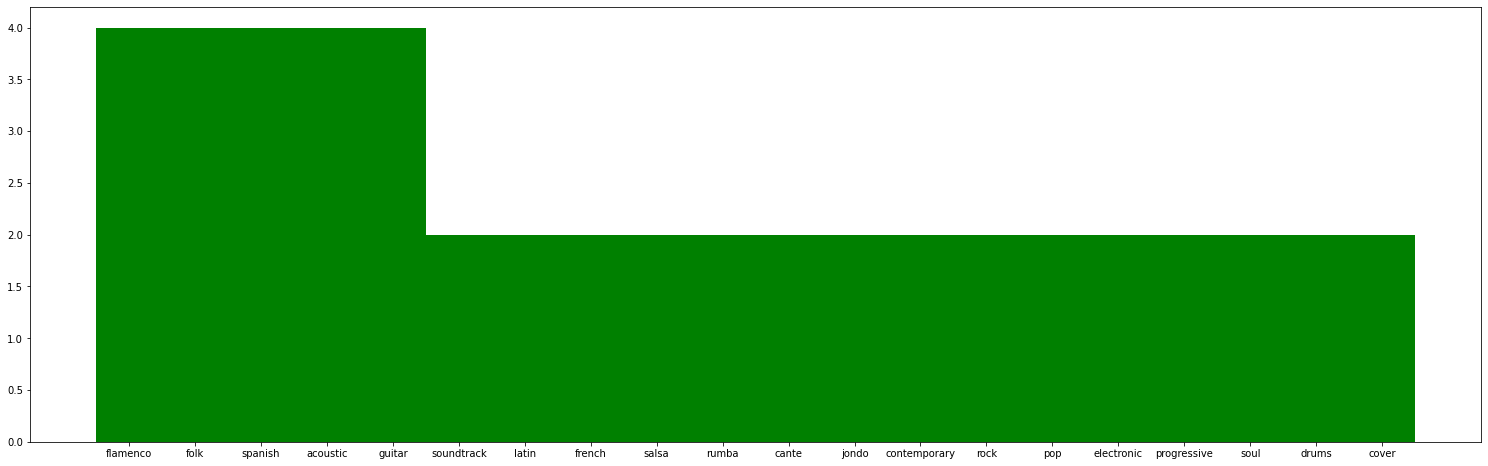

In [299]:
plt.figure(figsize = (26, 8), facecolor = None)
plt.bar(user_tf_if.keys(), user_tf_if.values(), 1, color='g')


In [300]:
user_tfidf = getTFIDFuser('b80344d063b5ccb3212f76538f3d9e43d87dca9e')


first2pairs = {k: user_tfidf[k] for k in list(user_tfidf)[:7]}
user_favourite_tags = []


for genre, weight in first2pairs.items():
    print(genre, ' : ',weight)
    user_favourite_tags.append(genre)

print(user_favourite_tags)

flamenco  :  4.0
folk  :  4.0
spanish  :  4.0
acoustic  :  4.0
guitar  :  4.0
soundtrack  :  2.0
latin  :  2.0
['flamenco', 'folk', 'spanish', 'acoustic', 'guitar', 'soundtrack', 'latin']


In [301]:
item_tags_for_finding_songs = []

for items in ml_freq_pairs:
    res = len(set(user_favourite_tags) & set(items))
    uncommon_elements = set(user_favourite_tags) ^ set(items)
    if(res >= 5 ):
        #print(items)
        item_tags_for_finding_songs.append(uncommon_elements)   

In [302]:
songid_matches = {}

for index, row in songs_cleaned.iterrows():
    
    res = len(set(user_favourite_tags) & set(row['artist_terms']))
    if(res >= 6 ):
        songid_matches[row['song_id']] = res
        #print(res)
    
    #uncommon_elements = set(user_favourite_tags) ^ set(items)
    #print(row)

In [303]:

a = dict(sorted(songid_matches.items(), key=lambda x: x[1],  reverse=True) )
top10recommended = {k: a[k] for k in list(a)[:10]}

top10recommended

{'SOWEZSI12A81C21CE6': 7}

In [304]:
test_list1 = [5, 6, 4, 10, 7, 1, 19]
test_list2 = [6, 6, 10, 3, 7, 10, 19]
 
# printing original lists
print("The original list 1 is : " + str(test_list1))
print("The original list 2 is : " + str(test_list2))
 
# Identical element summation in lists
# using set() + len()
res = len(set(test_list1) & set(test_list2));
 
# printing result
print("Summation of Identical elements : " + str(res))

The original list 1 is : [5, 6, 4, 10, 7, 1, 19]
The original list 2 is : [6, 6, 10, 3, 7, 10, 19]
Summation of Identical elements : 4


# Evaluation
* song is a good recommendation if it is the same genre

we decide that a it is a good recommendation if half the genres overlap. Between the query and the recommendations

In [269]:

def evaluate(query, recommendations):
    K = 10 # number of retrieved items to query song
    aps = []
    for i, song in enumerate(recommended_songs):
        p = np.zeros(K)  # precisions at k
        r = np.zeros(K)  # recalls at k
        df.song[]
        y_true = query # genres of the query
        y_pred = 1 # genres of the recommendation

        # k ranking
        for k in range(1, K+1):
            tp = np.sum((y_true == y_pred[:k]))

            p[k-1] = tp/len(y_pred[:k])
            # fraction of objects predicted to be positive among all positive objects
            r[k-1] = tp/K
            # True Positive Identification Rate (TPIR): 
            # Probability of observing the correct identity within the top K ranks

        # binarize predictions
        y_pred[y_pred != y_true] = 0
        y_pred[y_pred == y_true] = 1

        ap = 1/(y_pred.sum() + 1e-9) * (p @ y_pred)
        aps.append(ap)

    maP = np.mean(aps)
    return maP

SyntaxError: invalid syntax (Temp/ipykernel_5732/2027355703.py, line 8)

In [270]:
songs_to_
for user in users:
    recommendation = get_recommendation(song)

NameError: name 'songs_to_' is not defined